In [4]:
#chargement des fichiers
import pandas as pd
import networkx as nx
import os
import numpy as np

base_dir = os.path.dirname(os.getcwd())
csv_path = os.path.join(base_dir, "Data", "processed", "trajets_stations_pollution.csv")
df = pd.read_csv(csv_path)
df_edges = pd.read_csv(csv_path)

base_dir1 = os.path.dirname(os.getcwd())
csv_path1 = os.path.join(base_dir1, "Data", "processed", "graphe_station_boolean.csv")
df_pollution = pd.read_csv(csv_path1)

# verifie le contenu affiche les 5 premieres lignes
df_edges.head(), df_pollution.head()

(                  station1                   station2  connected  \
 0     Château de Vincennes                    Bérault       True   
 1                 Châtelet            Louvre - Rivoli       True   
 2                 Châtelet             Hôtel de Ville       True   
 3  Esplanade de la Défense            Pont de Neuilly       True   
 4  Esplanade de la Défense  La Défense (Grande Arche)       True   
 
    temps_trajet_min  pollution_moyenne  lat_station1  lon_station1  \
 0              0.78                1.0     48.844318      2.440540   
 1              0.37                1.5     48.859225      2.345761   
 2              0.47                1.5     48.859225      2.345761   
 3              0.65                2.0     48.888350      2.249931   
 4              0.88                1.5     48.888350      2.249931   
 
    lat_station2  lon_station2 ligne_metro  
 0     48.845492      2.429228     Métro 1  
 1     48.860907      2.340996     Métro 1  
 2     48.857352     

In [5]:
# construction du graphe avec poids de pollution
G = nx.Graph()

# Fusionner les deux DataFrames pour avoir la pollution associée à chaque connexion
df_merged = pd.merge(df_edges, df_pollution, on=["station1", "station2"], how="inner")

# Ajouter les arêtes au graphe avec le poids = pollution moyenne
for _, row in df_merged.iterrows():
    G.add_edge(row['station1'], row['station2'], weight=row['pollution_moyenne'])

# Nombre de sommets et d'arêtes pour vérification
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
nb_nodes, nb_edges


(91, 52)

In [8]:
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh

# on converti le graphe en matrice et on transforme le graphe en matrice d'adjacence. 
# C'est une grille avec 1 ou une valeur si deux stations sont connectees

A = nx.to_numpy_array(G, weight="weight")  # on garde le poids (pollution) comme valeur

#calcule le laplacien normalise, le laplacien sert a etudier comment le signal circule dans le graphe
#ici on choisit le laplacien normalise car les connexions sont pas egales entre toutes les stations

L = laplacian(A, normed=True)

#decomposition spectrale, on calcule les valeurs propres et vecteurs propres.  ils vont nous dire comment le graphe est structure et ou la pollution se concentre

eigvals, eigvecs = eigh(L)

# on affiche les 10 plus petites valeurs propres
eigvals[:10]


array([-6.45157559e-15, -4.20785232e-15, -3.37906308e-15, -2.92735439e-15,
       -2.01324457e-15, -1.44656623e-15, -3.61049788e-16,  2.33521803e-17,
        1.08041413e-16,  4.39824775e-16])

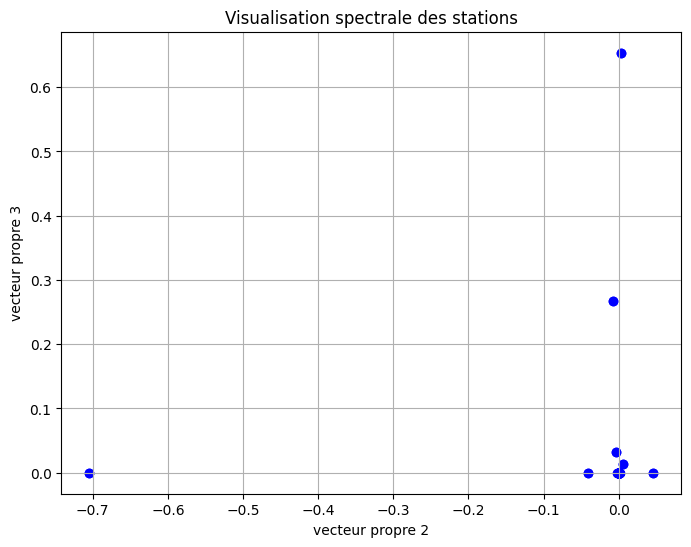

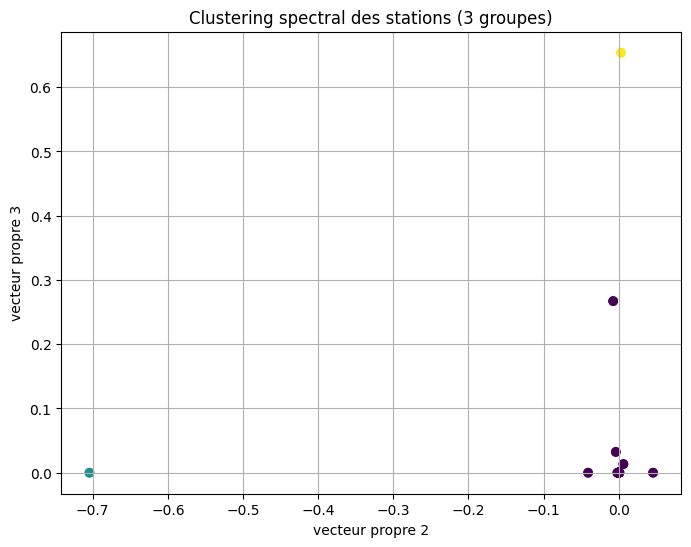

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#on choisit les vecteurs propres 2 et 3 (pas celui de valeur 0); ces vecteurs montrent les directions principales dans le graphe

vec2 = eigvecs[:, 1]  # 2eme plus petit vecteur propre
vec3 = eigvecs[:, 2]  # 3eme plus petit vecteur propre

#  on fait un nuage de points, chaque point est une station, les couleurs representent les zones qui reagissent pareil a la pollution

plt.figure(figsize=(8, 6))
plt.scatter(vec2, vec3, c='blue')
plt.xlabel("vecteur propre 2")
plt.ylabel("vecteur propre 3")
plt.title("Visualisation spectrale des stations")
plt.grid(True)
plt.show()

# clustering avec KMeans pour regrouperr les stations en 3 groupes selon leur position dans le plan spectral

X = np.vstack((vec2, vec3)).T  # on met les deux vecteurs ensemble
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X)

# meme graphe mais avec couleurs selon les clusters trouves
plt.figure(figsize=(8, 6))
plt.scatter(vec2, vec3, c=labels, cmap='viridis')
plt.xlabel("vecteur propre 2")
plt.ylabel("vecteur propre 3")
plt.title("Clustering spectral des stations (3 groupes)")
plt.grid(True)
plt.show()


In [11]:
# on reliste les noms des stations et leur cluster (groupe spectral)
# on utilise df_merged qui contient les noms de stations connectees

#on prend tous les noms de stations dans l'ordre du graphe
stations = list(G.nodes)

#on fait un tableau avec les noms de stations et leur groupe spectral
df_clusters = pd.DataFrame({
    "station": stations,
    "cluster": labels
})

# on affiche les 10 premieres lignes pour verifier
df_clusters.head(10)

#on recupere l'ordre exact des noeuds dans la matrice A
# cet ordre est le meme que celui utilise pour les vecteurs propres
station_order = list(nx.to_numpy_array(G, weight="weight").astype(float))

#on recalcule proprement l'ordre des stations depuis le graphe
station_list = list(G.nodes())

# on fait un tableau correct avec les labels de cluster selon l'ordre des vecteurs propres
df_clusters_corrected = pd.DataFrame({
    "station": station_list,
    "cluster": labels
})

# on compte le nombre de stations par cluster
df_clusters_corrected['cluster'].value_counts().sort_index()



cluster
0    87
1     2
2     2
Name: count, dtype: int64

In [15]:
# Lister les stations par cluster
stations_by_cluster = df_clusters_corrected.groupby("cluster")["station"].apply(list)

# Recuperer les coordonnees depuis df_pollution pour QGIS
# On prend toutes les stations (1 et 2) avec leurs coordonnees moyennes

# On construit un tableau avec les noms + lat/lon
stations_geo_1 = df_edges[["station1", "lat_station1", "lon_station1"]].rename(
    columns={"station1": "station", "lat_station1": "lat", "lon_station1": "lon"})
stations_geo_2 = df_edges[["station2", "lat_station2", "lon_station2"]].rename(
    columns={"station2": "station", "lat_station2": "lat", "lon_station2": "lon"})

# Fusionner et enlever les doublons
stations_geo = pd.concat([stations_geo_1, stations_geo_2]).drop_duplicates(subset="station")

# Joindre les clusters
stations_geo_clustered = pd.merge(df_clusters_corrected, stations_geo, on="station", how="left")

#Graphe spectral colore par pollution (moyenne par station)
# On recalcule la pollution moyenne par station
pollution_long = pd.concat([
    df_edges[["station1", "pollution_moyenne"]].rename(columns={"station1": "station"}),
    df_edges[["station2", "pollution_moyenne"]].rename(columns={"station2": "station"})
])

pollution_mean = pollution_long.groupby("station").mean().reset_index()

# Fusionner avec les vecteurs propres
station_list = list(G.nodes())
df_plot = pd.DataFrame({
    "station": station_list,
    "x": eigvecs[:, 1],
    "y": eigvecs[:, 2]
})
df_plot = pd.merge(df_plot, pollution_mean, on="station", how="left")

#Ecriture d'une analyse auto + affichage resultat tableau QGIS
stations_geo_clustered.to_csv("stations_qgis_clusters.csv", index=False)


stations_by_cluster, df_plot.head()


(cluster
 0    [Château de Vincennes, Bérault, George V, Fran...
 1                        [Porte Dauphine, Victor Hugo]
 2               [Aimé Césaire, Mairie d'Aubervilliers]
 Name: station, dtype: object,
                  station    x    y  pollution_moyenne
 0   Château de Vincennes  0.0  0.0              1.000
 1                Bérault  0.0  0.0              1.250
 2               George V  0.0  0.0              1.000
 3  Franklin D. Roosevelt  0.0  0.0              1.625
 4   Boulogne Jean Jaurès  0.0  0.0              2.000)